In [2]:
import numpy as np

N = 1000000  # 1M bus stops
tau = 10     # average time b/t stop

rng = np.random.default_rng(42)
bus_arrival_times = N * tau * np.sort(rng.uniform(size=N))

In [4]:
intervals = np.diff(bus_arrival_times)
intervals.mean()

10.000005922009166

In [12]:
def simulate_wait_times(arrival_times,
                        rseed=8675309,
                        n_passengers=1000000):
    rand = np.random.RandomState(rseed)

    arrival_times = np.asanyarray(arrival_times)
    passenger_times = arrival_times.max() * rand.rand(n_passengers)  # passengers arrive between 0 and last bus

    # find the index of the next bus for each simulated passenger
    i = np.searchsorted(arrival_times, passenger_times, side='right')

    return arrival_times[i] - passenger_times

In [11]:
wait_times = simulate_wait_times(bus_arrival_times)
wait_times.mean()

10.016130236019551

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Text(0, 0.5, 'Probability density')

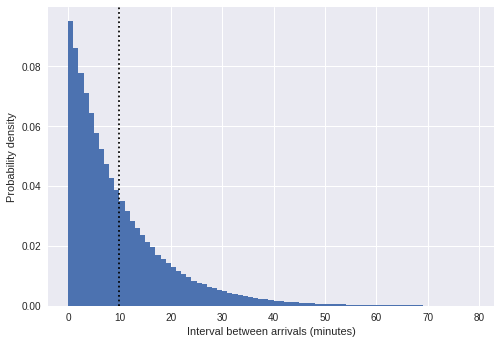

In [15]:
plt.hist(intervals, bins=np.arange(80), density=True)
plt.axvline(intervals.mean(), color='black', linestyle='dotted')
plt.xlabel('Interval between arrivals (minutes)')
plt.ylabel('Probability density');

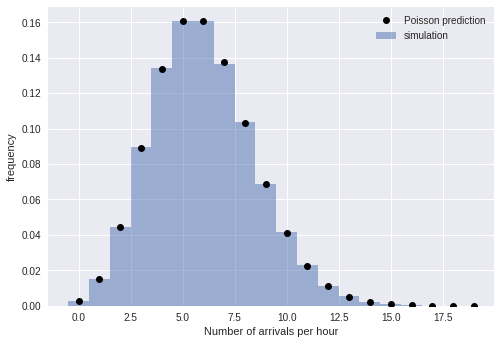

In [16]:
from scipy.stats import poisson

# count the number of arrivals in 1-hour bins
binsize = 60
binned_arrivals = np.bincount((bus_arrival_times // binsize).astype(int))
x = np.arange(20)

# plot the results
plt.hist(binned_arrivals, bins=x-0.5, density=True, alpha=0.5, label='simulation')
plt.plot(x, poisson(binsize / tau).pmf(x), 'ok', label='Poisson prediction')
plt.xlabel('Number of arrivals per hour')
plt.ylabel('frequency')
plt.legend();

# BART Ridership Hourly Dataset

In [21]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('../input/bart/date-hour-soo-dest-2022.csv', names=["Date", "Hour", "Origin", "Destination", "Exits"])
df = df.dropna(axis=0, how='any')
df["Time"] = pd.to_datetime(df.Date + ' ' + df.Hour.astype(str) + ":00:00")
# df = df[["Time", "Origin", "Destination", "Exits"]]
df.head()

,Date,Hour,Origin,Destination,Exits,Time
0,2022-01-01,0,12TH,12TH,1,2022-01-01
1,2022-01-01,0,12TH,16TH,1,2022-01-01
2,2022-01-01,0,12TH,24TH,2,2022-01-01
3,2022-01-01,0,12TH,ASHB,1,2022-01-01
4,2022-01-01,0,12TH,MONT,1,2022-01-01


In [40]:
df["Weekday"] = df["Time"].dt.weekday

In [3]:
df.Exits.sum()

30823177

In [4]:
df.Origin.unique()

array(['12TH', '16TH', '19TH', '24TH', 'ANTC', 'ASHB', 'BALB', 'BAYF',
       'CAST', 'CIVC', 'COLM', 'COLS', 'DALY', 'DBRK', 'DELN', 'DUBL',
       'EMBR', 'FRMT', 'FTVL', 'GLEN', 'HAYW', 'LAFY', 'LAKE', 'MCAR',
       'MLBR', 'MLPT', 'MONT', 'NBRK', 'OAKL', 'ORIN', 'PCTR', 'PHIL',
       'PITT', 'PLZA', 'POWL', 'RICH', 'ROCK', 'SANL', 'SBRN', 'SFIA',
       'SSAN', 'UCTY', 'WARM', 'WCRK', 'WOAK', 'BERY', 'CONC', 'NCON',
       'SHAY', 'WDUB'], dtype=object)

In [41]:
# look at Walnut Creek to SF
places = ['WCRK', 'EMBR']
mask = df.Origin.isin(places) & df.Destination.isin(places)
weekday_mask = df["Weekday"] < 5
stations = df[mask & weekday_mask]

In [44]:
daily_ridership = df.groupby("Date")["Exits"].sum()

In [50]:
daily_ridership.index = pd.to_datetime(daily_ridership.index)

In [59]:
daily_ridership

Date
2022-01-01     34747
2022-01-02     34742
2022-01-03     77037
2022-01-04     82748
2022-01-05     85427
               ...  
2022-09-28    177358
2022-09-29    174668
2022-09-30    156027
2022-10-01    101349
2022-10-02     73833
Name: Exits, Length: 275, dtype: int64

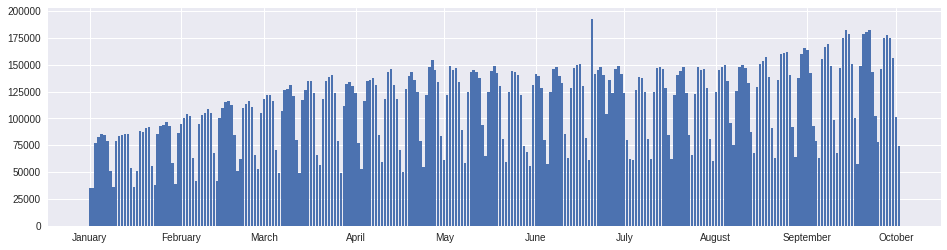

In [69]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(16, 4))
ax.bar(daily_ridership.index, daily_ridership.values)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))

In [71]:
daily_ridership.idxmax()

Timestamp('2022-06-20 00:00:00')

In [73]:
warriors_parade = df[df["Date"] == "2022-06-20"]

<AxesSubplot:xlabel='Hour', ylabel='Exits'>

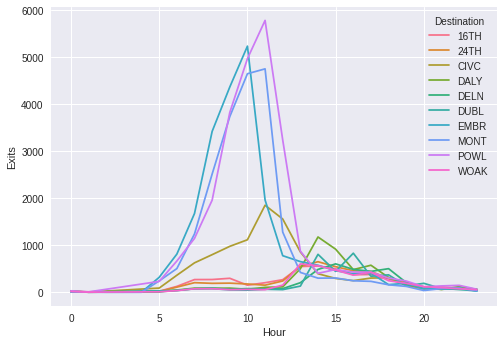

In [104]:
biggest_stations = warriors_parade.groupby(["Destination"])["Exits"].sum().sort_values(ascending=False)
warr_dest = warriors_parade["Destination"].isin(biggest_stations.index[:10])
warr_rides = warriors_parade[warr_dest].groupby(["Destination", "Hour"])["Exits"].sum()
sns.lineplot(data=warr_rides.reset_index(), x="Hour", y="Exits", hue="Destination")

<AxesSubplot:xlabel='Hour', ylabel='Exits'>

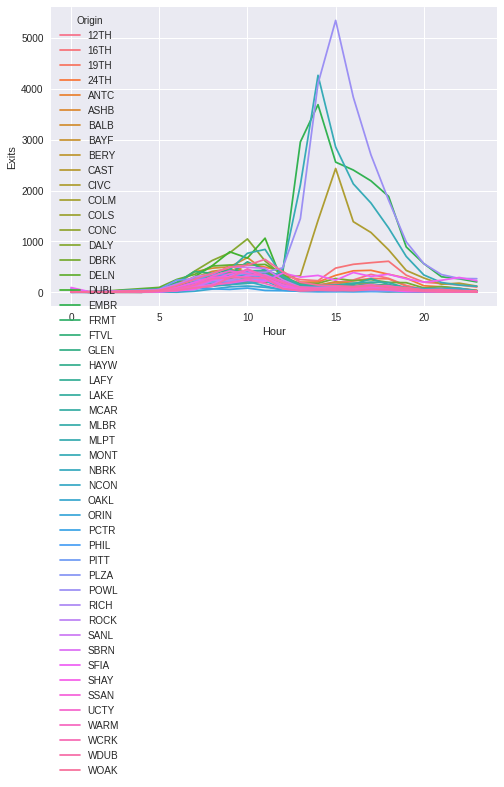

In [109]:
origin = warriors_parade["Origin"].isin(biggest_stations.index[:10])
origin_rides = warriors_parade.groupby(["Origin", "Hour"])["Exits"].sum()
sns.lineplot(data=origin_rides.reset_index(), x="Hour", y="Exits", hue="Origin")

In [33]:
dest_means = df.groupby(["Destination", "Hour"]).mean()

In [39]:
dest_means.groupby("Destination").max().sort_values(by="Exits", ascending=False)

,Exits
Destination,
EMBR,39.065501
MONT,37.020054
CIVC,20.977689
POWL,18.056242
DALY,14.118534
BALB,13.858133
DELN,11.914677
24TH,11.642663
WOAK,11.439524
